In [1]:
import pandas as pd

In [2]:
credit_df = pd.read_csv('credit_risk_dataset.csv')

In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [5]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [10]:
# Separate data into two sets: one with missing values and one without
df_missing = credit_df[credit_df['person_emp_length'].isnull()]
df_not_missing = credit_df[~credit_df['person_emp_length'].isnull()]

In [11]:
# define the features (independent variables) and target (person_emp_length)
# use 'person_income' and 'loan_amnt' as features
features = ['person_income', 'loan_amnt']
target = 'person_emp_length'

In [14]:
# Create and fit a linear regression model on the data without missing values
regression_model = LinearRegression()
regression_model.fit(df_not_missing[features], df_not_missing[target])

LinearRegression()

In [15]:
# Predict the missing values
imputed_values = regression_model.predict(df_missing[features])

In [16]:
# update the DataFrame with the imputed values
credit_df.loc[credit_df['person_emp_length'].isnull(), 'person_emp_length'] = imputed_values

In [17]:
# doing the same for 'loan_int_rate'
# split into two - one with missing, the other without
df_missing = credit_df[credit_df['loan_int_rate'].isnull()]
df_not_missing = credit_df[~credit_df['loan_int_rate'].isnull()]

In [18]:
# define the features (independent variables) and target (loan_int_rate)
# using 'person_income' and 'loan_amnt' as features
features = ['person_income', 'loan_amnt']
target = 'loan_int_rate'

In [19]:
# create and fit a linear regression model on the data without missing values
regression_model = LinearRegression()
regression_model.fit(df_not_missing[features], df_not_missing[target])

LinearRegression()

In [20]:
# predict the missing values
imputed_values = regression_model.predict(df_missing[features])

In [21]:
#update the DataFrame with the imputed values
credit_df.loc[credit_df['loan_int_rate'].isnull(), 'loan_int_rate'] = imputed_values

In [22]:
# using logistic regression to predict probable values for new "probability of default" column
# including 'cb_person_default_on_file' as a feature for this regression model
# one-hot encoding to convert 'cb_person_default_on_file' into numeric format
X = pd.get_dummies(credit_df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'cb_person_default_on_file', 'loan_grade']], columns=['cb_person_default_on_file', 'loan_grade'], drop_first=True)
y = credit_df['loan_status']
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

# predicting pd
pd_values = logistic_model.predict_proba(X)[:, 1]  # Probability of Default

# adding pd values to existing dataframe
credit_df['pd'] = pd_values


In [23]:
credit_df['ead'] = credit_df['loan_amnt'] - credit_df['loan_amnt'] * credit_df['loan_percent_income']
# to calculate exposure at default

In [24]:
# adding a column for loss given default using recovery rate
# calculating recovery rate
credit_df['recovery_rate'] = (credit_df['ead'] - (credit_df['pd'] * credit_df['ead'])) / credit_df['ead']

# calculating loss given default as a percentage
credit_df['lgd'] = (1 - credit_df['recovery_rate']) * 100

In [40]:

X=pd.get_dummies(credit_df[['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length',
 'ead',
 'recovery_rate',
 'lgd']], columns=['cb_person_default_on_file', 'loan_grade', 'loan_intent', 'person_home_ownership'], drop_first=True)
y=credit_df['pd']

In [41]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,ead,recovery_rate,...,loan_grade_F,loan_grade_G,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
32377,64,46000,2.0,4800,11.090000,0,0.10,24,4320.0,0.795647,...,0,0,0,0,0,1,0,0,0,1
1338,26,26000,0.0,8500,16.450000,1,0.33,3,5695.0,0.537605,...,0,0,0,0,0,0,0,0,1,0
7047,23,51000,3.0,16000,13.110000,0,0.31,3,11040.0,0.590841,...,0,0,0,0,0,1,0,0,0,0
8225,22,56004,6.0,6000,7.880000,0,0.11,4,5340.0,0.837299,...,0,0,0,0,1,0,0,0,0,0
7178,24,79000,3.0,7000,12.540000,0,0.09,3,6370.0,0.921808,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,39,38500,7.0,3500,13.980000,0,0.09,17,3185.0,0.767259,...,0,0,0,0,1,0,0,0,0,0
5390,25,69000,5.0,8500,6.920000,1,0.12,4,7480.0,0.869916,...,0,0,0,1,0,0,0,0,0,1
860,26,148000,1.0,20000,17.990000,1,0.14,3,17200.0,0.979908,...,0,0,0,0,0,0,0,0,0,1
15795,26,175000,0.0,15000,11.212599,0,0.09,3,13650.0,0.996007,...,0,0,0,0,0,1,0,0,0,0


In [47]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(26,)),  #input shape should match number of variables in data
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  #output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
list(X)

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'ead',
 'recovery_rate',
 'lgd',
 'cb_person_default_on_file_Y',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT']

In [49]:
from sklearn.preprocessing import StandardScaler
#scaling data with standard scaler
scaler = StandardScaler()
#fit scaler on training and apply same scaling to test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# train
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)

PermutationExplainer explainer: 6518it [06:14, 16.92it/s]                          


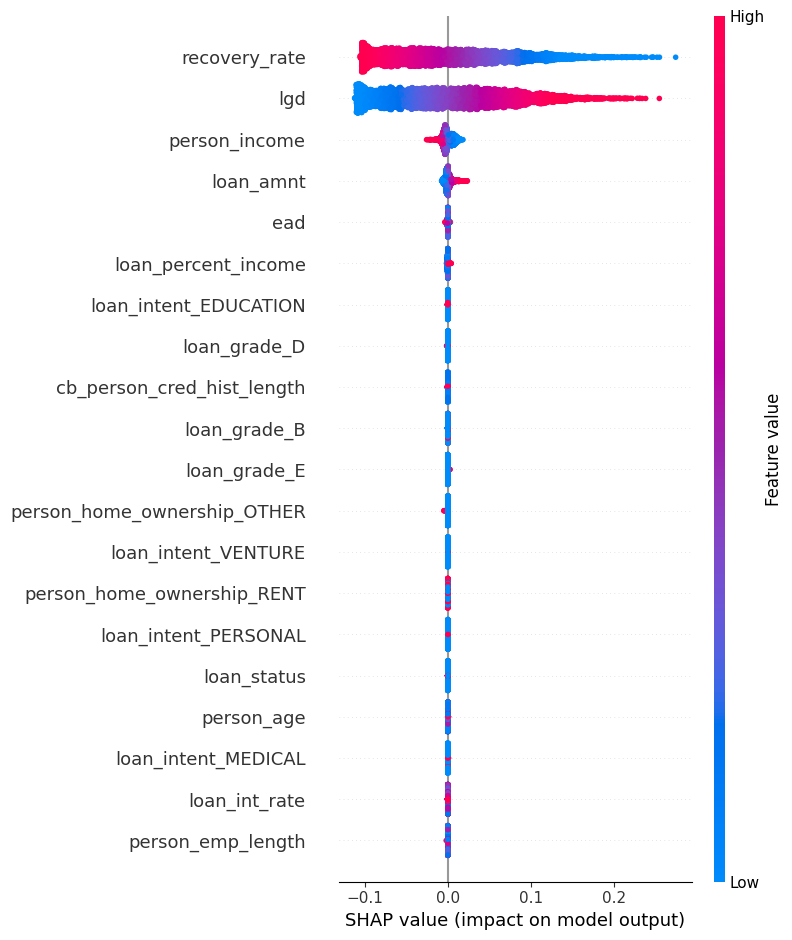

In [56]:


#explainer initialized
explainer = shap.Explainer(model, X_train_scaled)

#shap values
shap_values = explainer(X_test_scaled)

#plot summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'ead',
 'recovery_rate',
 'lgd',
 'cb_person_default_on_file_Y',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT'])


In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [59]:
# defining x and y values again
x = credit_df[['recovery_rate', 'lgd']]
y=credit_df['pd']

In [60]:
#splitting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [61]:
#scaling data with standard scaler
scaler = StandardScaler()
#fit scaler on training and apply same scaling to test
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [64]:
# Building FFNN for regression (predicting 'pd')
model = keras.Sequential()
model.add(layers.Input(shape=(x_train_scaled.shape[1],)))  # input layer
model.add(layers.Dense(128, activation='relu'))  # hidden layer
model.add(layers.Dropout(0.3))  # dropout layer to target potential overfitting
model.add(layers.Dense(64, activation='relu'))  # second hidden layer
model.add(layers.Dense(1, activation='linear'))  # output layer for regression

In [65]:
# Compile the model (choose the appropriate loss function and metrics)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [66]:
# Train the model
model.fit(x_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(x_test_scaled, y_test))

Epoch 1/100
815/815 [==============================] - 4s 3ms/step - loss: 0.0013 - mae: 0.0197 - mse: 0.0013 - val_loss: 3.3011e-04 - val_mae: 0.0107 - val_mse: 3.3011e-04
Epoch 2/100
815/815 [==============================] - 2s 2ms/step - loss: 1.4234e-04 - mae: 0.0081 - mse: 1.4234e-04 - val_loss: 3.6300e-04 - val_mae: 0.0131 - val_mse: 3.6300e-04
Epoch 3/100
815/815 [==============================] - 3s 4ms/step - loss: 9.9477e-05 - mae: 0.0068 - mse: 9.9477e-05 - val_loss: 4.6107e-04 - val_mae: 0.0172 - val_mse: 4.6107e-04
Epoch 4/100
815/815 [==============================] - 2s 2ms/step - loss: 6.7124e-05 - mae: 0.0056 - mse: 6.7124e-05 - val_loss: 5.9399e-04 - val_mae: 0.0173 - val_mse: 5.9399e-04
Epoch 5/100
815/815 [==============================] - 2s 3ms/step - loss: 5.6275e-05 - mae: 0.0051 - mse: 5.6275e-05 - val_loss: 6.4123e-04 - val_mae: 0.0189 - val_mse: 6.4123e-04
Epoch 6/100
815/815 [==============================] - 2s 2ms/step - loss: 4.3548e-05 - mae: 0.0046 - m

In [68]:
# Evaluate the model
loss, mae, mse = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test MSE: {mse:.4f}")

204/204 [==============================] - 1s 4ms/step - loss: 0.0022 - mae: 0.0404 - mse: 0.0022
Test Loss: 0.0022, Test MAE: 0.0404, Test MSE: 0.0022


In [70]:
# Predict 'pd' values for the test data
y_pred = model.predict(x_test_scaled)


204/204 [==============================] - 1s 2ms/step


In [71]:
# Calculate the loss, MAE, and MSE
loss, mae, mse = model.evaluate(x_test_scaled, y_pred)

# Display the loss and evaluation metrics
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test MSE: {mse:.4f}")

204/204 [==============================] - 1s 3ms/step - loss: 8.9523e-17 - mae: 3.6012e-09 - mse: 8.9523e-17
Test Loss: 0.0000, Test MAE: 0.0000, Test MSE: 0.0000


In [74]:
y_pred

array([[0.411461  ],
       [0.20144963],
       [0.23650552],
       ...,
       [0.0963905 ],
       [0.09924196],
       [0.3785213 ]], dtype=float32)

In [75]:
y_test

14668    0.482010
24614    0.177015
11096    0.227610
10424    0.482050
26007    0.395763
           ...   
31330    0.074386
2862     0.092477
14754    0.027358
14170    0.031422
24385    0.435031
Name: pd, Length: 6517, dtype: float64

In [72]:
import matplotlib.pyplot as plt


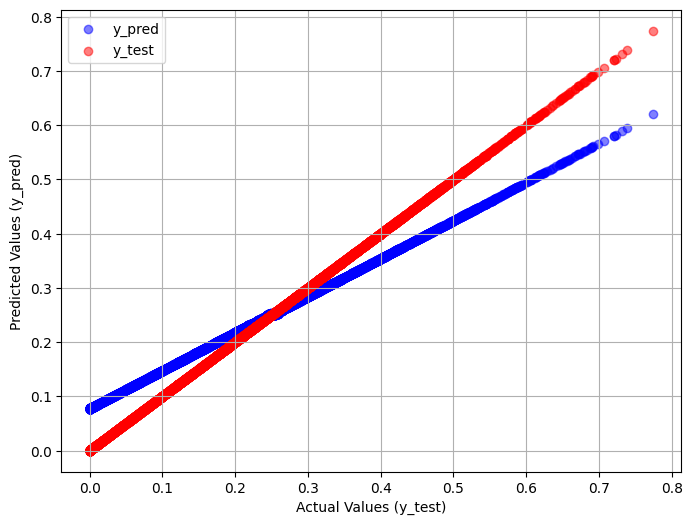

In [73]:
# Create a scatter plot with different colors for y_pred and y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='y_pred', c='blue', marker='o')
plt.scatter(y_test, y_test, alpha=0.5, label='y_test', c='red', marker='o')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.grid(True)
plt.legend()
plt.show()